In [1]:
import mplfinance as mpf
import pymssql
import json
import pandas as pd
import numpy as np

db_settings = {
    "host": "172.30.52.193",
    "port": 1433,
    "user": "sa",
    "password": "255089",
    "database": "ncudb",
    "charset": "utf8"
}

In [15]:
try:  
    conn = pymssql.connect(**db_settings)
    with conn.cursor() as cursor:
        command = " SELECT t1.[date], o, h, l, c, v , buy_or_sell \
                    FROM stock_price t1 \
                    LEFT JOIN dbo.GB_rule1_5('2330') t2 \
                    ON t1.date = t2.date \
                    WHERE stock_code = '2330' \
                    ORDER BY t1.[date] ASC;"
        cursor.execute(command)
        result = cursor.fetchall()
except Exception as ex:
    print(ex)

conn.close()

In [19]:
arr = []
for r in result:
    r = list(r)
    r[0] = r[0];
    r[1] = float(r[1])
    r[2] = float(r[2])
    r[3] = float(r[3])
    r[4] = float(r[4])
    r[5] = float(r[5])
    r[6] = 0 if r[6] == None else int(r[6])
    arr.append(r)

In [20]:
arr_df = pd.DataFrame(arr)
arr_df.index = pd.to_datetime(arr_df[0])
arr_df = arr_df.drop(columns=[0])
arr_df.columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'BuyOrSell']
arr_df.index.name = 'Date'
arr_df

,Open,High,Low,Close,Volume,BuyOrSell
Date,,,,,,
2021-01-04,530.0,540.0,528.0,536.0,33316.0,0
2021-01-05,536.0,542.0,535.0,542.0,28512.0,0
2021-01-06,555.0,555.0,541.0,549.0,55462.0,0
2021-01-07,554.0,570.0,553.0,565.0,47905.0,0
2021-01-08,580.0,580.0,571.0,580.0,56426.0,0
...,...,...,...,...,...,...
2023-03-13,513.0,518.0,509.0,516.0,24150.0,0
2023-03-14,511.0,514.0,510.0,510.0,24848.0,0
2023-03-15,515.0,516.0,510.0,511.0,21075.0,0


In [43]:
def buy_signal(buy_or_sell, price):
    signal = []
    for i in range(len(buy_or_sell)):
        if buy_or_sell[i] == 1:
            signal.append(price[i] * 1.01)
        else:
            signal.append(np.nan)
    return signal 
def sell_signal(buy_or_sell, price):
    signal = []
    for i in range(len(buy_or_sell)):
        if buy_or_sell[i] == -1:
            signal.append(price[i] * 1.01)
        else:
            signal.append(np.nan)
    return signal

In [44]:
buy = buy_signal(arr_df['BuyOrSell'], arr_df['Close'])
sell = sell_signal(arr_df['BuyOrSell'], arr_df['Close'])

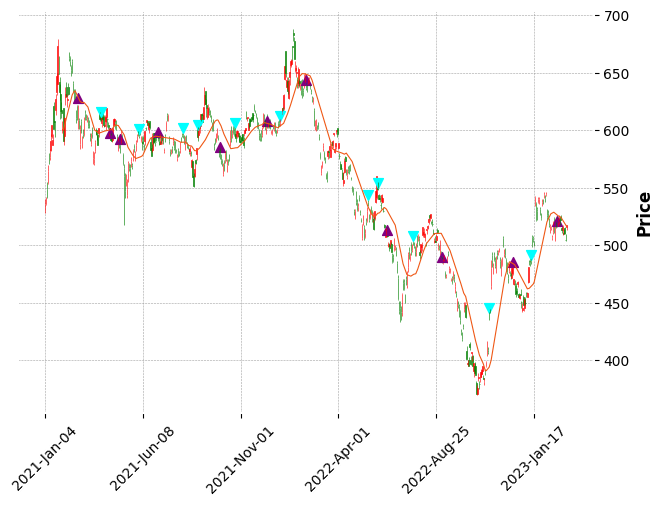

In [45]:
mc = mpf.make_marketcolors(up='r',
                           down='g',
                           edge='',
                           wick='inherit',
                           volume='inherit')
s = mpf.make_mpf_style(base_mpf_style='charles', marketcolors=mc)
apds = [
    mpf.make_addplot(buy, type='scatter', markersize=50, marker='v', color='aqua'),
    mpf.make_addplot(sell, type='scatter', markersize=50, marker='^', color='purple')
    ]

mpf.plot(arr_df, addplot=apds, type='candle', style=s, mav=(20))